The objective of the final data pipeline is parsing each column of the CSV file into the correct data type and save the new data as Parquet file.

# 1. `games_description.csv`

The file wraps all columns as a string and have many columns with nested data types. Attempt to parse the data type from the start did not work. It's a challenge to process the column, which I actually welcomed 🤗.

Schema:
```
name: string
short_description: string
long_description: string
genres: object (array[string])
minimum_system_requirement: object (struct[string])
recommend_system_requirement: object (struct[string])
release_date: date
developer: object (array[string])
publisher: object (array[string])
overall_player_rating: categorical
number_of_reviews_from_purchased_people: int32
number_of_english_reviews: int32
link: string
```

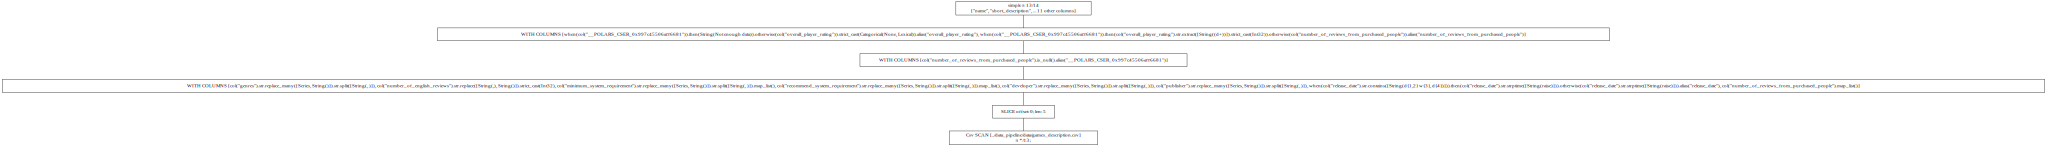

In [5]:
import polars as pl
from pathlib import Path
import re

local_dir = Path("../data_pipeline/data")


def parse_reviews(value):
    if "%" in value:
        # Extract percentage and total number
        match = re.search(r"(\d+)% of ([\d,]+)", value)
        if match:
            percentage = int(match.group(1))
            total = int(match.group(2).replace(",", ""))
            return int((percentage / 100) * total)
    else:
        # Extract the number directly
        match = re.search(r"\(([\d,]+)\)", value)
        if match:
            return int(match.group(1).replace(",", ""))


def parse_system_requirements(requirements_list):
    result = {}
    for item in requirements_list:
        if ":" in item:
            key, value = item.split(":")[:2]
            result[key.strip()] = value.strip()
    return result


df = pl.scan_csv(local_dir / "games_description.csv")
df = df.with_columns(
    pl.col("genres").str.replace_many(["]", "'", "["], "").str.split(", "),
    pl.col("number_of_english_reviews").str.replace_all(",", "").cast(pl.Int32),
    pl.col(["minimum_system_requirement", "recommend_system_requirement"])
    .str.replace_many(["]", "'", "["], "")
    .str.split(", ")
    .map_elements(parse_system_requirements, return_dtype=pl.Struct),
    pl.col(["developer", "publisher"])
    .str.replace_many(["]", "'", "["], "")
    .str.split(", "),
    pl.when(pl.col("release_date").str.contains(r"\d{1,2} \w{3}, \d{4}"))
    .then(pl.col("release_date").str.to_date("%d %b, %Y", strict=False))
    .otherwise(pl.col("release_date").str.to_date("%b %Y", strict=False))
    .alias("release_date"),
    pl.col("number_of_reviews_from_purchased_people").map_elements(
        parse_reviews, return_dtype=pl.Int32
    ),
)

df = df.with_columns(
    pl.when(pl.col("number_of_reviews_from_purchased_people").is_null())
    .then(pl.lit("Not enough data"))
    .otherwise(pl.col("overall_player_rating"))
    .cast(pl.Categorical("lexical"))
    .alias("overall_player_rating"),
    pl.when(pl.col("number_of_reviews_from_purchased_people").is_null())
    .then(pl.col("overall_player_rating").str.extract(r"(\d+)").cast(pl.Int32))
    .otherwise(pl.col("number_of_reviews_from_purchased_people"))
    .alias("number_of_reviews_from_purchased_people"),
)

df.head().show_graph()

In [25]:
df.select("overall_player_rating").unique().head(11).collect()

overall_player_rating
cat
"""Overwhelmingly Positive"""
"""Very Positive"""
"""Mixed"""
"""Mostly Positive"""
"""Mostly Negative"""
"""Very Negative"""
"""Not enough data"""
"""Positive"""


# 2. `games_ranking.csv`

The file is significantly easier to parse.

Schema:
```
game_name: string
genre: categorical
rank_type: categorical
rank: uint8
```

In [2]:
import polars as pl
from pathlib import Path

local_dir = Path("/teamspace/studios/this_studio/Steam-RecSys/data_pipeline/data")
schema = pl.Schema(
    {
        "game_name": pl.String(),
        "genre": pl.Categorical(),
        "rank_type": pl.Categorical(),
        "rank": pl.UInt8(),
    }
)

df = pl.read_csv(local_dir / "games_ranking.csv", schema=schema)

df.select(pl.all().is_null().sum())

game_name,genre,rank_type,rank
u32,u32,u32,u32
0,0,0,0


# 3. `steam_game_reviews.csv`

The file is the most important: our actual game review dataset. The most important thing is to parse the reviews into a suitable format for the recommendation system.

Schema:
```

```

In [61]:
import polars as pl
from pathlib import Path
from datetime import datetime

local_dir = Path("/teamspace/studios/this_studio/Steam-RecSys/data_pipeline/data")


def parse_date_without_year(date_str):
    try:
        # Try "Day Month" format
        return datetime.strptime(date_str, "%d %B").replace(year=2024).date()
    except ValueError:
        try:
            # Try "Month Day" format
            return datetime.strptime(date_str, "%B %d").replace(year=2024).date()
        except ValueError as e:
            print(f"Error parsing date: {e}")
            raise ValueError(date_str)


df = pl.scan_csv(local_dir / "steam_game_reviews.csv", infer_schema_length=10000)

df = df.with_columns(
    pl.col("hours_played").str.replace_all(",", "").cast(pl.Float32),
    pl.col(["helpful", "funny"]).str.replace_all(",", "").cast(pl.Int64),
    pl.col("recommendation").cast(pl.Categorical("lexical")),
    pl.when(pl.col("date").str.contains(r"\w+ \d{1,2}, \d{4}"))
    .then(pl.col("date").str.to_date("%B %d, %Y", strict=False))
    .when(pl.col("date").str.contains(r"\d{1,2} \w+, \d{4}"))
    .then(pl.col("date").str.to_date("%d %B, %Y", strict=False))
    .when(pl.col("date").str.contains(r"^(\d{1,2} \w+|\w+ \d{1,2})$"))
    .then(pl.col("date").map_elements(parse_date_without_year, return_dtype=pl.Date))
    .alias("date"),
    pl.when(pl.col("username").str.contains("\n"))
    .then(pl.col("username").str.extract(r"^(.*?)\n"))
    .otherwise(pl.col("username")),
)

df.select(pl.col("date").is_null().sum()).collect()

# df.filter(
#     pl.col("username").str.contains_any(
#         [
#             "САКАКОК",
#             "Ryuzaki Ken",
#             "zakheron",
#             "toxic40",
#             "MiddayEnglishman",
#             "StarOutOfSpace",
#             "galacticdude7",
#         ]
#     )
# ).collect()

Error parsing date: unconverted data remains: , 2015
Error parsing date: unconverted data remains: , 2015
Error parsing date: unconverted data remains: , 2016
Error parsing date: time data '31 March, 2023' does not match format '%B %d'


thread 'polars-0' panicked at crates/polars-python/src/map/series.rs:1089:26:
called `Result::unwrap()` on an `Err` value: PyErr { type: <class 'ValueError'>, value: ValueError('31 March, 2023'), traceback: Some(<traceback object at 0x7fc4fa126180>) }
--- PyO3 is resuming a panic after fetching a PanicException from Python. ---
Python stack trace below:


PanicException: called `Result::unwrap()` on an `Err` value: PyErr { type: <class 'ValueError'>, value: ValueError('31 March, 2023'), traceback: Some(<traceback object at 0x7fc4fa126180>) }

PanicException: called `Result::unwrap()` on an `Err` value: PyErr { type: <class 'ValueError'>, value: ValueError('31 March, 2023'), traceback: Some(<traceback object at 0x7fc4fa126180>) }